In [7]:
# Cell 1: imports + generate synthetic dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib
import json

np.random.seed(42)

n = 200
student_ids = [f"S{str(i).zfill(3)}" for i in range(1, n+1)]
names = [f"Student {i}" for i in range(1, n+1)]
classes = np.random.choice(["Class A", "Class B", "Class C"], size=n, p=[0.4,0.35,0.25])

# cognitive skills (0-100-ish) and engagement_time in minutes per week (5-120)
comprehension = np.clip(np.random.normal(70, 10, n), 30, 100)
attention = np.clip(np.random.normal(65, 15, n), 10, 100)
focus = np.clip(np.random.normal(60, 15, n), 5, 100)
retention = np.clip(np.random.normal(68, 12, n), 20, 100)
engagement_time = np.clip(np.random.normal(40, 15, n), 5, 120)

# Create assessment_score as a weighted combination + noise, then clip to 0-100
raw_score = (
    0.30 * comprehension +
    0.25 * attention +
    0.20 * focus +
    0.15 * retention +
    0.10 * (engagement_time * 0.8)  # scale engagement_time roughly to 0-100 scale
)
assessment_score = np.clip(raw_score + np.random.normal(0, 5, n), 0, 100)

df = pd.DataFrame({
    "student_id": student_ids,
    "name": names,
    "class": classes,
    "comprehension": np.round(comprehension, 2),
    "attention": np.round(attention, 2),
    "focus": np.round(focus, 2),
    "retention": np.round(retention, 2),
    "engagement_time": np.round(engagement_time, 1),
    "assessment_score": np.round(assessment_score, 2)
})

# quick peek
df.head()


,student_id,name,class,comprehension,attention,focus,retention,engagement_time,assessment_score
0,S001,Student 1,Class A,63.20,77.86,77.52,56.29,21.2,60.88
1,S002,Student 2,Class C,72.32,62.60,63.82,80.64,61.7,60.52
2,S003,Student 3,Class B,72.93,64.71,65.06,56.61,38.8,70.87
3,S004,Student 4,Class B,62.86,49.96,53.82,99.59,56.8,66.64
4,S005,Student 5,Class A,88.66,64.72,52.69,73.92,45.1,64.57


                  count      mean        std    min      25%     50%      75%  \
comprehension     200.0  70.63145   9.540543  37.59  63.3425  70.895  76.6650   
attention         200.0  64.09560  14.955194  27.93  53.0950  64.115  73.7975   
focus             200.0  59.54205  15.186864  19.55  50.3300  59.575  69.5725   
retention         200.0  70.09315  11.317543  41.61  61.7050  70.175  76.4925   
engagement_time   200.0  41.99900  14.672601   5.00  32.9500  42.950  51.6500   
assessment_score  200.0  63.02085   8.039838  37.69  57.3150  62.445  69.1150   

                     max  
comprehension     100.00  
attention         100.00  
focus              98.60  
retention          99.59  
engagement_time    76.10  
assessment_score   90.25  


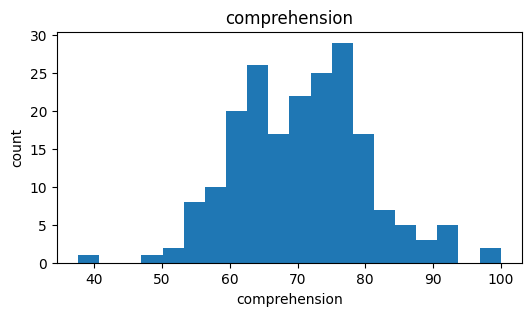

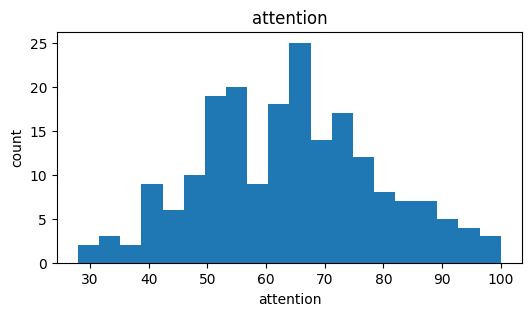

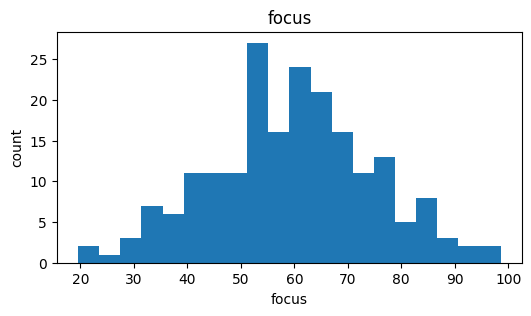

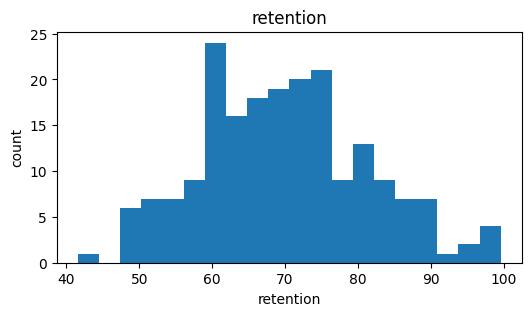

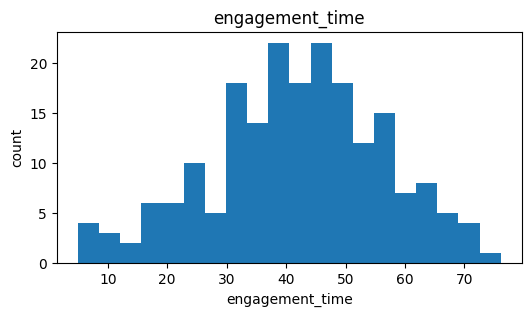

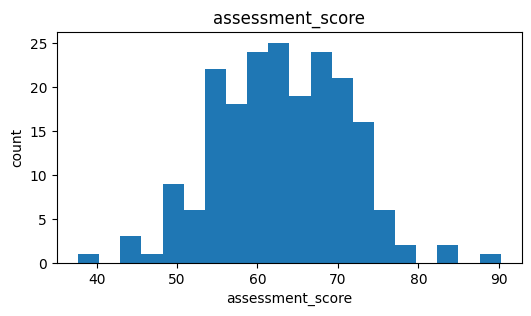

In [8]:
# Cell 2: EDA: describe and distributions
print(df.describe().T)

# Histograms (one by one - each plot on its own)
for col in ["comprehension","attention","focus","retention","engagement_time","assessment_score"]:
    plt.figure(figsize=(6,3))
    plt.hist(df[col], bins=20)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()


Correlation matrix:
                   comprehension  attention  focus  retention  engagement_time  \
comprehension             1.000     -0.069 -0.081     -0.030           -0.014   
attention                -0.069      1.000  0.103     -0.008           -0.066   
focus                    -0.081      0.103  1.000      0.141            0.014   
retention                -0.030     -0.008  0.141      1.000            0.121   
engagement_time          -0.014     -0.066  0.014      0.121            1.000   
assessment_score          0.272      0.491  0.443      0.292            0.176   

                  assessment_score  
comprehension                0.272  
attention                    0.491  
focus                        0.443  
retention                    0.292  
engagement_time              0.176  
assessment_score             1.000  


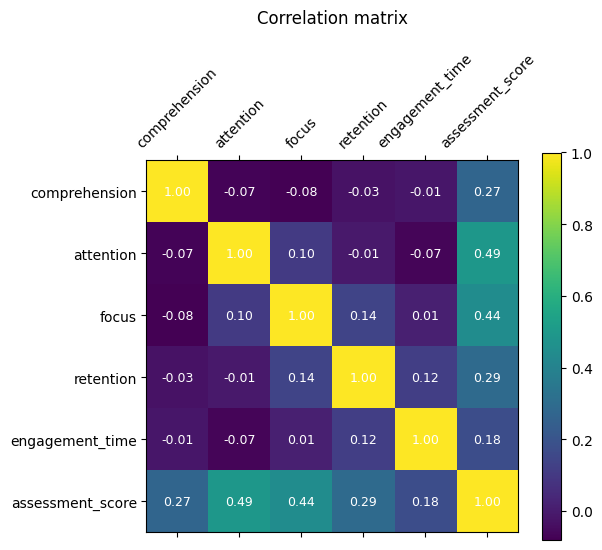

In [9]:
# Cell 3: Correlations
corr = df[["comprehension","attention","focus","retention","engagement_time","assessment_score"]].corr()
print("Correlation matrix:\n", corr.round(3))

# visualize heatmap with matplotlib (no seaborn)
plt.figure(figsize=(6,5))
mat = plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(mat)
# Annotate values
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', color='white', fontsize=9)
plt.title("Correlation matrix", pad=20)
plt.show()


In [10]:
# Cell 4: Pearson r between each cognitive skill and assessment_score
from scipy.stats import pearsonr

skills = ["comprehension","attention","focus","retention","engagement_time"]
corrs = {}
for s in skills:
    r, p = pearsonr(df[s], df["assessment_score"])
    corrs[s] = (r, p)
sorted_corrs = sorted(corrs.items(), key=lambda x: -abs(x[1][0]))
for k, (r,p) in sorted_corrs:
    print(f"{k}: r={r:.3f}, p={p:.3e}")


attention: r=0.491, p=1.507e-13
focus: r=0.443, p=4.926e-11
retention: r=0.292, p=2.688e-05
comprehension: r=0.272, p=9.607e-05
engagement_time: r=0.176, p=1.287e-02


In [13]:
# Cell: ML models (robust RMSE calculation)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import numpy as np

features = ["comprehension","attention","focus","retention","engagement_time"]
X = df[features].values
y = df["assessment_score"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

def print_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))   # robust: works on all sklearn versions
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

print_metrics(y_test, y_pred_lr, "LinearRegression")
print_metrics(y_test, y_pred_rf, "RandomForest")

# Feature importances (Random Forest)
importances = rf.feature_importances_
for f, imp in sorted(zip(features, importances), key=lambda x: -x[1]):
    print(f"{f}: importance={imp:.3f}")

# Save model (optional)
joblib.dump(rf, "rf_assessment_model.joblib")
print("Saved Random Forest model to rf_assessment_model.joblib")


LinearRegression -> MAE: 4.307, RMSE: 5.359, R2: 0.534
RandomForest -> MAE: 4.284, RMSE: 5.829, R2: 0.449
attention: importance=0.272
focus: importance=0.268
retention: importance=0.174
comprehension: importance=0.173
engagement_time: importance=0.112
Saved Random Forest model to rf_assessment_model.joblib


In [14]:
# Cell 6: Clustering (KMeans) to define learning personas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# pick k=3 (you can run elbow method)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# cluster centers (in original scale)
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=features)
centers_df["cluster"] = range(k)
print("Cluster centers (approx original scale):")
print(centers_df)

# cluster summary
print(df.groupby("cluster")[features + ["assessment_score"]].mean().round(2))
print(df.groupby("cluster").size())


Cluster centers (approx original scale):
   comprehension  attention      focus  retention  engagement_time  cluster
0      70.815410  55.422787  58.272459  80.809344        47.880328        0
1      75.673056  59.030556  51.951111  61.895417        36.773611        1
2      65.046119  77.434776  68.855373  69.146119        42.259701        2
         comprehension  attention  focus  retention  engagement_time  \
cluster                                                                
0                70.82      55.42  58.27      80.81            47.88   
1                75.67      59.03  51.95      61.90            36.77   
2                65.05      77.43  68.86      69.15            42.26   

         assessment_score  
cluster                    
0                   62.78  
1                   60.40  
2                   66.06  
cluster
0    61
1    72
2    67
dtype: int64


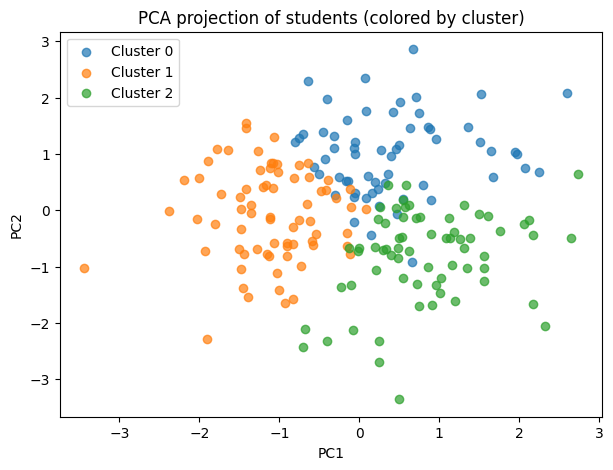

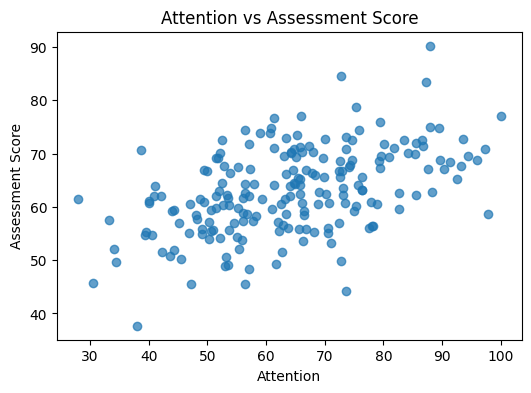

In [15]:
# Cell 7: PCA 2D plot for cluster visualization
pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)
df["pc1"] = pc[:,0]
df["pc2"] = pc[:,1]

plt.figure(figsize=(7,5))
for cluster in sorted(df["cluster"].unique()):
    subset = df[df["cluster"]==cluster]
    plt.scatter(subset["pc1"], subset["pc2"], label=f"Cluster {cluster}", alpha=0.7)
plt.legend()
plt.title("PCA projection of students (colored by cluster)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Scatter: attention vs assessment_score
plt.figure(figsize=(6,4))
plt.scatter(df["attention"], df["assessment_score"], alpha=0.7)
plt.xlabel("Attention")
plt.ylabel("Assessment Score")
plt.title("Attention vs Assessment Score")
plt.show()


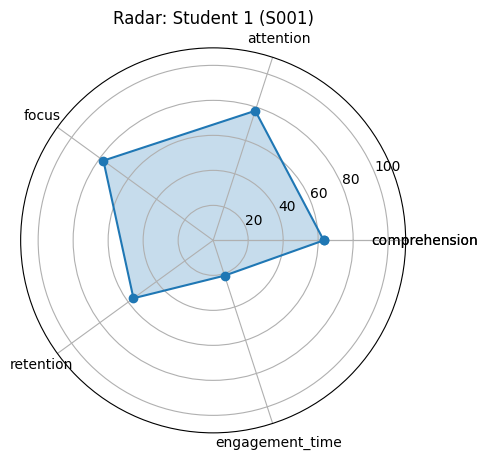

In [17]:
def plot_radar(student_row, features=["comprehension","attention","focus","retention","engagement_time"]):
    # Extract values
    values = [student_row[f] for f in features]
    labels = features
    
    # Close loop for values and labels
    values += values[:1]
    labels += labels[:1]   # 👈 add this line
    
    # Angles for radar
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=True)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, marker='o')
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title(f"Radar: {student_row['name']} ({student_row['student_id']})")
    ax.set_ylim(0, 110)
    plt.show()

# Test with the first student
plot_radar(df.iloc[0])


In [18]:
# Cell 9: Save dataset (CSV + public JSON)
df.to_csv("students.csv", index=False)
df.to_json("students.json", orient="records", indent=2)
print("Saved students.csv and students.json in current directory.")


Saved students.csv and students.json in current directory.
